In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import math
import warnings
warnings.filterwarnings("ignore")

data1 = pd.read_csv("../../resource/ModelCreation/worldVaccinesCleanSimple.csv")
data1.date = pd.to_datetime(data1.date,format="%Y-%m-%d") # Convert date strings to datetime objects
mindate1 = data1.date.min() # Save min for when we take in input
data1.date = data1.date - data1.date.min()
data1.date = pd.Series([x.days for x in data1.date])
data1["people_fully_vaccinated_per_hundred"] = data1["people_fully_vaccinated_per_hundred"]/100
datadict1 = dict()
for c in data1.country.unique():
    tmpdata = data1.loc[data1.country==c] # Get the data where the country column equals the certain country
    tmpdata.drop("country",axis=1,inplace=True) # Drop the country column because this value will be the same for this table
    datadict1[c] = {"data":tmpdata} # Set the value for the key at country c to be the data we just extracted

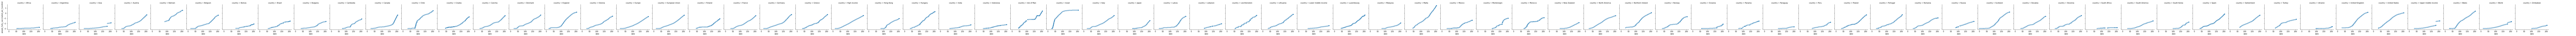

In [2]:
data = [] # Create empty list to put data to graph into
for c in datadict1.keys(): # Loop through each country
    graphData = datadict1[c]["data"].copy() # Make a copy of the country's data
    graphData = graphData.loc[:,["date","people_fully_vaccinated_per_hundred"]] # Extract the date and fully vac columns
    transformationY = lambda y: -1*math.log(((1/(y+.05))-1))
    graphData["people_fully_vaccinated_per_hundred"] = [transformationY(y) if y != -1 else -10 for y in graphData["people_fully_vaccinated_per_hundred"]]
    graphData["country"] = c
    data.append(graphData) # Add graph data to the list
graph = sns.FacetGrid(pd.concat(data),col="country") # Create a Facet grid to create multiple graphs
graph.map(sns.scatterplot, "date", "people_fully_vaccinated_per_hundred") # Create many different scatter plots
graph.add_legend() # Add a legend

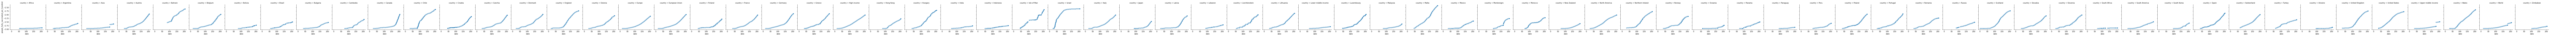

In [3]:
data = [] # Create empty list to put data to graph into
for c in datadict1.keys(): # Loop through each country
    graphData = datadict1[c]["data"].copy() # Make a copy of the country's data
    graphData = graphData.loc[:,["date","people_fully_vaccinated_per_hundred"]] # Extract the date and fully vac columns
    transformationY = lambda y: -1*math.log(((1/((y*.2)+.05))-1))
    graphData["people_fully_vaccinated_per_hundred"] = [transformationY(y) if y != -1 else -10 for y in graphData["people_fully_vaccinated_per_hundred"]]
    graphData["country"] = c
    data.append(graphData) # Add graph data to the list
graph = sns.FacetGrid(pd.concat(data),col="country") # Create a Facet grid to create multiple graphs
graph.map(sns.scatterplot, "date", "people_fully_vaccinated_per_hundred") # Create many different scatter plots
graph.add_legend() # Add a legend

In [7]:
def transform_x(x_data, log_bool):
    """Transforms x values based on the bool passed in

    Either leaves the X value the same for a Linear Model
    Or adds a new row that has logarithmic values

    Args:
        x_data: the x values to be transformed
        log_bool: a boolean to say whether to use a

    Returns:
        returns the transformed x values
    """
    if not log_bool:
        return x_data
    new_x = []
    # Loop through each row in the list
    for row in x_data:
        new_values = []
        # Loop through each possible transformation
        for val in row:
            new_values.append(math.log(val+2))
        new_x.append(np.append(row, new_values))
    return new_x

def transform_y_fit(y_data):
    """Transforms the Y values into a logistic form

    Creates a lambda in order to transform all of the y values
    Uses a list comprehension to loop through all the y values and transform them

    Args:
        y_data: the people_fully_vaccinated_per_hundred column for the country

    Returns:
        A list that holds the transformed y values
    """
    # Create a lambda with formula to transform values.
    transformation = lambda y: -1*math.log((1/(y+.01))-1)
    return [transformation(y) if y < .99 else 10 for y in y_data]

def transform_y_predict(y_data):
    """Transforms the Y values into the non-logistic form

    Creates a lambda in order to transform all of the y values
    Uses a list comprehension to loop through all the y values and transform them

    Args:
        y_data: the people_fully_vaccinated_per_hundred column for the country

    Returns:
        A list that holds the transformed y values
    """
    transformation = lambda y: (1/(1+math.exp(-1*y)))-.01
    return [transformation(y) if y > -70 else 0 for y in y_data]

class LogisticLogarithmicRegressionModel:
    """This Class is a wrapper in order to fit and predict a model

    The Class accepts a dataframe when initialized, then splits that into x and y components
    From there, it tests whether a linear or logarithmic model would be better
    The model overall, fits to a logistic curve by transforming the y values
    Then, this class can make predictions based on x values

    Attributes:
        x_data: holds the x component of the data
        y_data: holds the y component of the data
        model: holds the trained model
        score: holds the r-squared value from the model
        bool: holds a bool for whether or not to use a logarithmic transformation
    """

    def __init__(self, dataframe):
        """Initialize data with X and y portions and call find_regress

        Extracts the x and y values from an inputed dataframe
        This function sets the x_data and y_data attributes

        Args:
            dataframe: a dataframe with a date and people_fully_vaccinated_per_hundred column
        """
        self.x_data = dataframe["date"].to_numpy().reshape(-1, 1)
        self.y_data = dataframe["people_fully_vaccinated_per_hundred"]
        self.find_regress()


    def find_regress(self):
        """Checks whether a logarithmic curve or linear curve is better

        Creates a model for a linear and logarithmic curve and compares
        the r-squared values to decide which model to use
        This function sets the model, score, and bool attributes
        """
        # Set an initial model and score from fitting our model
        self.model, self.score = self.fit(True)
        self.bool = True
        tmp_model, tmp_score = self.fit(False)
        # Check if this new model has a better score
        if tmp_score > self.score:
            # If the new model has a better score, update the model, score, and regress_bool
            self.model = tmp_model
            self.score = tmp_score
            self.bool = False

    def fit(self, log_bool):
        """Transforms the x and y values, then fits the model, returning the model and score

        Calls transform_x and transform_y_fit in order to transform x and y values
        The function then fits a model using the sklearn LinearRegression

        Args:
            bool: a boolean value that says whether to use a
                  logarithmic curve, is passed to transform_x

        Returns:
            A fit model and the r-squared value from the curve
        """
        x_data = transform_x(self.x_data, log_bool)
        y_data = transform_y_fit(self.y_data.copy())
        model = LinearRegression().fit(x_data, y_data)
        score = model.score(x_data, y_data)
        return model, score

    def predict(self, x_data):
        """Creates a prediction based on x values

        Transforms the X value to make a prediction
        Then transforms the y value into the non-logistic version

        Args:
            x_data: A list of the dates to make a prediction on

        Returns:
            A list of people_fully_vaccinated_per_hundred values that the model predicts
        """
        x_data = transform_x(x_data.copy(), self.bool)
        return transform_y_predict(self.model.predict(x_data))


In [8]:
datadict1["United States"]["data"]["people_fully_vaccinated_per_hundred"].to_numpy()

array([0.004 , 0.0048, 0.006 , 0.0065, 0.0072, 0.0082, 0.0091, 0.0096,
       0.01  , 0.0104, 0.0114, 0.0127, 0.0143, 0.0157, 0.0169, 0.0177,
       0.0181, 0.0192, 0.0207, 0.0224, 0.0249, 0.0274, 0.0285, 0.0294,
       0.0313, 0.0335, 0.0361, 0.0391, 0.0421, 0.0449, 0.0463, 0.0483,
       0.0509, 0.0535, 0.0564, 0.0581, 0.0594, 0.0616, 0.0645, 0.0676,
       0.0709, 0.0741, 0.0761, 0.0782, 0.0806, 0.0831, 0.0858, 0.089 ,
       0.0918, 0.0942, 0.096 , 0.0984, 0.1013, 0.1047, 0.1104, 0.112 ,
       0.1146, 0.1167, 0.1196, 0.1225, 0.1254, 0.1287, 0.132 , 0.1343,
       0.1361, 0.1386, 0.1418, 0.1456, 0.1499, 0.1543, 0.1573, 0.1597,
       0.1633, 0.1677, 0.1734, 0.179 , 0.1836, 0.1866, 0.1884, 0.1926,
       0.198 , 0.2039, 0.2114, 0.2172, 0.2215, 0.2252, 0.2293, 0.2347,
       0.241 , 0.2466, 0.252 , 0.2552, 0.2578, 0.2619, 0.2668, 0.2726,
       0.2783, 0.2834, 0.2867, 0.2893, 0.2932, 0.298 , 0.3032, 0.3092,
       0.3133, 0.3155, 0.3175, 0.321 , 0.3257, 0.3315, 0.3368, 0.3416,
      

In [9]:
transform_y_predict(transform_y_fit(datadict1["United States"]["data"]["people_fully_vaccinated_per_hundred"].to_numpy()))

[0.004000000000000005,
 0.004800000000000007,
 0.005999999999999993,
 0.006499999999999994,
 0.007199999999999996,
 0.0082,
 0.009100000000000002,
 0.009599999999999996,
 0.010000000000000004,
 0.010399999999999998,
 0.011399999999999999,
 0.012699999999999998,
 0.014299999999999998,
 0.0157,
 0.0169,
 0.0177,
 0.018100000000000005,
 0.019200000000000002,
 0.020699999999999996,
 0.022399999999999996,
 0.02489999999999999,
 0.0274,
 0.028500000000000004,
 0.029399999999999996,
 0.03130000000000001,
 0.0335,
 0.03610000000000001,
 0.0391,
 0.04209999999999999,
 0.044899999999999995,
 0.04630000000000001,
 0.0483,
 0.0509,
 0.0535,
 0.0564,
 0.05809999999999999,
 0.0594,
 0.06160000000000001,
 0.0645,
 0.06759999999999998,
 0.07090000000000002,
 0.0741,
 0.0761,
 0.07820000000000002,
 0.08060000000000002,
 0.08310000000000001,
 0.0858,
 0.08900000000000001,
 0.09179999999999999,
 0.09420000000000002,
 0.09599999999999997,
 0.09839999999999999,
 0.10129999999999997,
 0.1047,
 0.11040000000